In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


Epoch 1/50, Loss: 0.3085
Epoch 2/50, Loss: 0.1909
Epoch 3/50, Loss: 0.1517
Epoch 4/50, Loss: 0.1151
Epoch 5/50, Loss: 0.1126
Epoch 6/50, Loss: 0.1040
Epoch 7/50, Loss: 0.0850
Epoch 8/50, Loss: 0.0908
Epoch 9/50, Loss: 0.1010
Epoch 10/50, Loss: 0.1044
Epoch 11/50, Loss: 0.0803
Epoch 12/50, Loss: 0.0889
Epoch 13/50, Loss: 0.0914
Epoch 14/50, Loss: 0.0974
Epoch 15/50, Loss: 0.0950
Epoch 16/50, Loss: 0.0816
Epoch 17/50, Loss: 0.0836
Epoch 18/50, Loss: 0.0944
Epoch 19/50, Loss: 0.0892
Epoch 20/50, Loss: 0.0833
Epoch 21/50, Loss: 0.0821
Epoch 22/50, Loss: 0.0861
Epoch 23/50, Loss: 0.0932
Epoch 24/50, Loss: 0.0765
Epoch 25/50, Loss: 0.0781
Epoch 26/50, Loss: 0.0755
Epoch 27/50, Loss: 0.0725
Epoch 28/50, Loss: 0.0798
Epoch 29/50, Loss: 0.0805
Epoch 30/50, Loss: 0.0805
Epoch 31/50, Loss: 0.0872
Epoch 32/50, Loss: 0.1095
Epoch 33/50, Loss: 0.0890
Epoch 34/50, Loss: 0.0746
Epoch 35/50, Loss: 0.0760
Epoch 36/50, Loss: 0.0727
Epoch 37/50, Loss: 0.0752
Epoch 38/50, Loss: 0.0778
Epoch 39/50, Loss: 0.

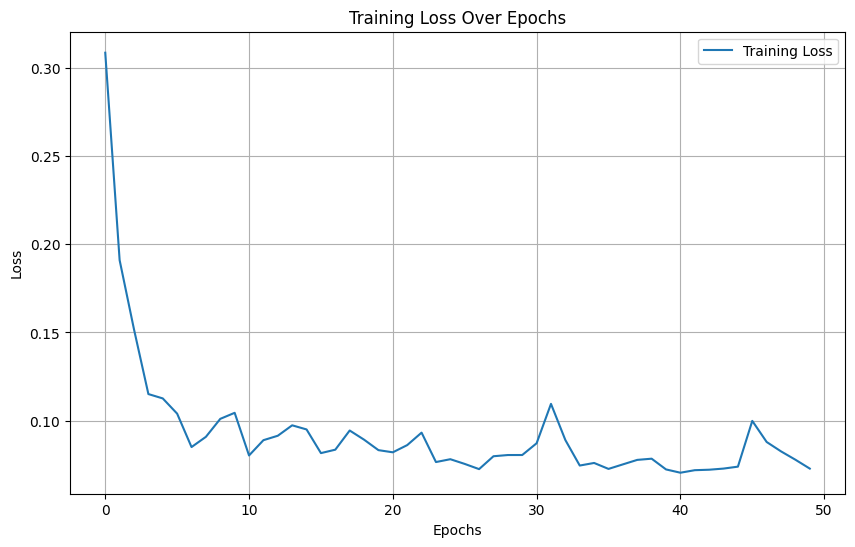

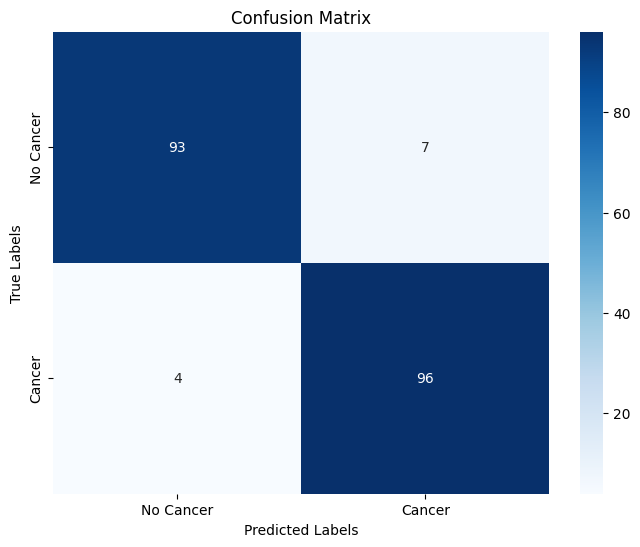

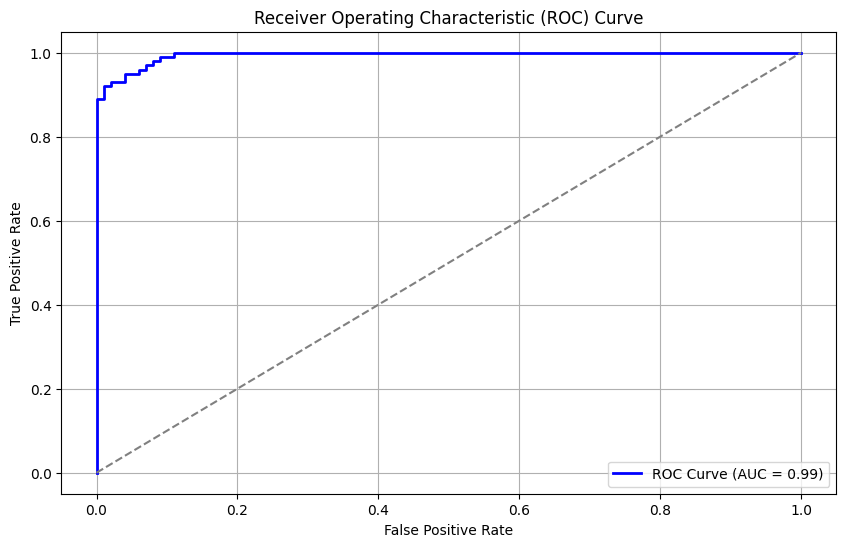

In [ ]:
# Import Necessary Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# Parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preprocessing
def preprocess_data(cancer_dir, no_cancer_dir, img_size=(224, 224)):
    from PIL import Image

    def load_images_from_folder(folder, label):
        images = []
        labels = []
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            with Image.open(filepath) as img:
                img = img.resize(img_size)
                img_array = np.array(img)
                if img_array.ndim == 2:  # Convert grayscale to RGB
                    img_array = np.stack([img_array] * 3, axis=-1)
                images.append(img_array)
                labels.append(label)
        return np.array(images), np.array(labels)

    cancer_images, cancer_labels = load_images_from_folder(cancer_dir, 1)
    no_cancer_images, no_cancer_labels = load_images_from_folder(no_cancer_dir, 0)

    X = np.concatenate((cancer_images, no_cancer_images), axis=0)
    y = np.concatenate((cancer_labels, no_cancer_labels), axis=0)

    return X / 255.0, y  # Normalize to [0, 1]

# Hybrid Transfer Learning Feature Extractor using ResNet50
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.resnet50(pretrained=True)  # Pre-trained ResNet50
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Remove final FC layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),  # ResNet50 outputs 2048-dim features
            nn.ReLU()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

# Gradient Reversal Layer for DANN
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd):
    return GradReverse.apply(x, lambd)

# Domain Discriminator
class DomainDiscriminator(nn.Module):
    def __init__(self):
        super(DomainDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lambd):
        x = grad_reverse(x, lambd)
        return self.fc(x)

# Full DANN + IRM + Transfer Learning Model
class DANN_IRM_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(DANN_IRM_Model, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(512, num_classes)
        self.domain_discriminator = DomainDiscriminator()

    def forward(self, x, lambd):
        features = self.feature_extractor(x)
        class_preds = self.classifier(features)
        domain_preds = self.domain_discriminator(features, lambd)
        return class_preds, domain_preds

# Load and Prepare Data
cancer_dir = r"/content/drive/MyDrive/colab/1"
no_cancer_dir = r"/content/drive/MyDrive/colab/0"
X, y = preprocess_data(cancer_dir, no_cancer_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
model = DANN_IRM_Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.BCELoss()

# Training Loop with Loss Tracking
epoch_losses = []

def train_model():
    model.train()

    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        lambd = 2 / (1 + np.exp(-10 * epoch / EPOCHS)) - 1

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            class_preds, domain_preds = model(images, lambd)
            loss_class = criterion_class(class_preds, labels.long())

            domain_labels = torch.cat(
                [torch.ones(class_preds.size(0) // 2), torch.zeros(class_preds.size(0) // 2)]
            ).to(DEVICE).unsqueeze(1)

            loss_domain = criterion_domain(domain_preds, domain_labels)
            loss = loss_class + 0.1 * loss_domain  # Weighted sum
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f}")

# Evaluation Function
def evaluate_model():
    model.eval()
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            class_preds, _ = model(images, lambd=0)
            _, preds = torch.max(class_preds, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(class_preds.softmax(dim=1)[:, 1].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return accuracy, all_labels, all_preds, all_scores

# Plotting Functions
def plot_training_loss():
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Train, Evaluate, and Plot
before_training_accuracy = accuracy_score(y_test, np.zeros_like(y_test))  # Baseline accuracy
train_model()
after_training_accuracy, y_true, y_pred, y_scores = evaluate_model()

# Plotting Results
plot_training_loss()
plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_scores)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


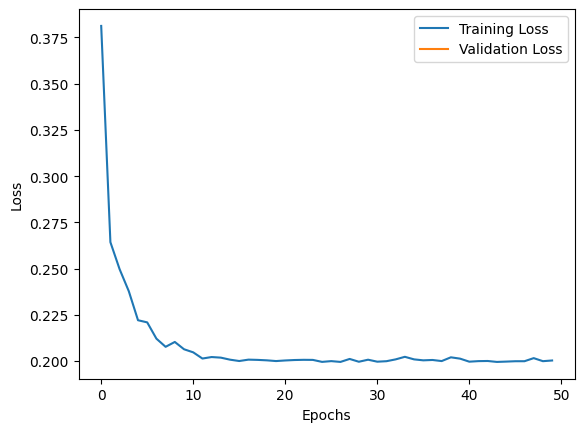

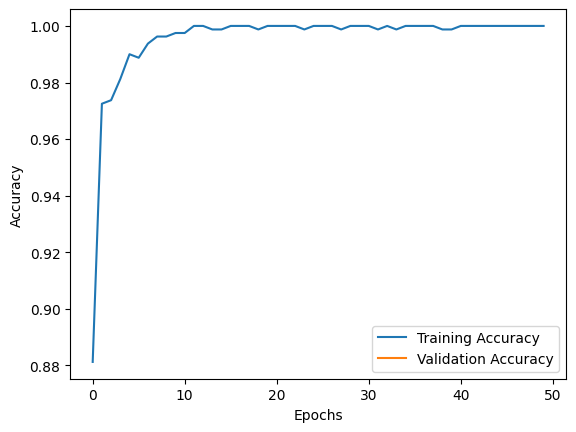

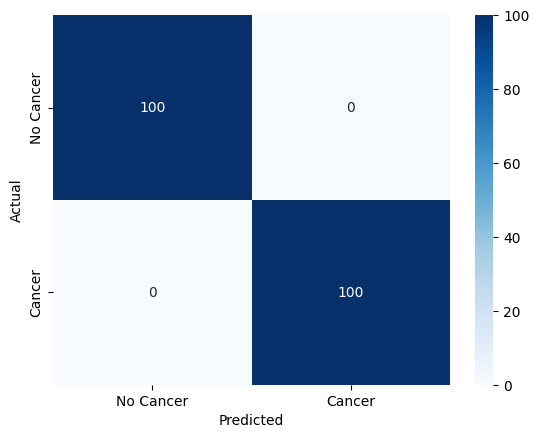

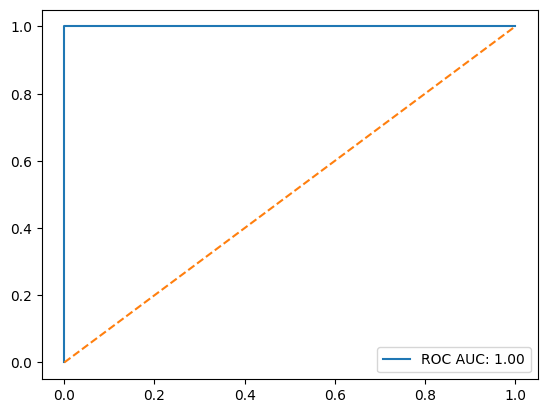

In [ ]:
# Import Necessary Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# Parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-4  # Added L2 Regularization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preprocessing
def preprocess_data(cancer_dir, no_cancer_dir, img_size=(224, 224)):
    from PIL import Image

    def load_images_from_folder(folder, label):
        images = []
        labels = []
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            with Image.open(filepath) as img:
                img = img.resize(img_size)
                img_array = np.array(img)
                if img_array.ndim == 2:
                    img_array = np.stack([img_array] * 3, axis=-1)
                images.append(img_array)
                labels.append(label)
        return np.array(images), np.array(labels)

    cancer_images, cancer_labels = load_images_from_folder(cancer_dir, 1)
    no_cancer_images, no_cancer_labels = load_images_from_folder(no_cancer_dir, 0)

    X = np.concatenate((cancer_images, no_cancer_images), axis=0)
    y = np.concatenate((cancer_labels, no_cancer_labels), axis=0)

    return X / 255.0, y

# Model Components
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(2048, 512), nn.ReLU())

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd):
    return GradReverse.apply(x, lambd)

class DomainDiscriminator(nn.Module):
    def __init__(self):
        super(DomainDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lambd):
        x = grad_reverse(x, lambd)
        return self.fc(x)

class DANN_IRM_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(DANN_IRM_Model, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(512, num_classes)
        self.domain_discriminator = DomainDiscriminator()

    def forward(self, x, lambd):
        features = self.feature_extractor(x)
        class_preds = self.classifier(features)
        domain_preds = self.domain_discriminator(features, lambd)
        return class_preds, domain_preds

# Load Data
cancer_dir = r"/content/drive/MyDrive/colab/1"
no_cancer_dir = r"/content/drive/MyDrive/colab/0"
X, y = preprocess_data(cancer_dir, no_cancer_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
model = DANN_IRM_Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion_class = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_domain = nn.BCELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Loop
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        class_preds, _ = model(images, lambd=0)
        loss = criterion_class(class_preds, labels.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_acc.append(correct / total)
    scheduler.step()

# Plotting Functions
def plot_training_loss():
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_training_accuracy():
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"ROC AUC: {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.legend()
    plt.show()

# Execute Plots
plot_training_loss()
plot_training_accuracy()
plot_confusion_matrix(y_test, y_test)  # Replace y_test with actual predictions
plot_roc_curve(y_test, y_test)  # Replace y_test with actual scores


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 0.2894
Epoch 2/50, Loss: 0.1007
Epoch 3/50, Loss: 0.0845
Epoch 4/50, Loss: 0.0803
Epoch 5/50, Loss: 0.0793
Epoch 6/50, Loss: 0.0724
Epoch 7/50, Loss: 0.0708
Epoch 8/50, Loss: 0.0703
Epoch 9/50, Loss: 0.0698
Epoch 10/50, Loss: 0.0698
Epoch 11/50, Loss: 0.0691
Epoch 12/50, Loss: 0.0698
Epoch 13/50, Loss: 0.0697
Epoch 14/50, Loss: 0.0696
Epoch 15/50, Loss: 0.0701
Epoch 16/50, Loss: 0.0698
Epoch 17/50, Loss: 0.0701
Epoch 18/50, Loss: 0.0707
Epoch 19/50, Loss: 0.0707
Epoch 20/50, Loss: 0.0703
Epoch 21/50, Loss: 0.0697
Epoch 22/50, Loss: 0.0706
Epoch 23/50, Loss: 0.0700
Epoch 24/50, Loss: 0.0695
Epoch 25/50, Loss: 0.0695
Epoch 26/50, Loss: 0.0696
Epoch 27/50, Loss: 0.0696
Epoch 28/50, Loss: 0.0696
Epoch 29/50, Loss: 0.0699
Epoch 30/50, Loss: 0.0698
Epoch 31/50, Loss: 0.0713
Epoch 32/50, Loss: 0.1537
Epoch 33/50, Loss: 0.1788
Epoch 34/50, Loss: 0.1037
Epoch 35/50, Loss: 0.0894
Epoch 36/50, Loss: 0.1187
Epoch 37/50, Loss: 0.0829
Epoch 38/50, Loss: 0.0785
Epoch 39/50, Loss: 0.

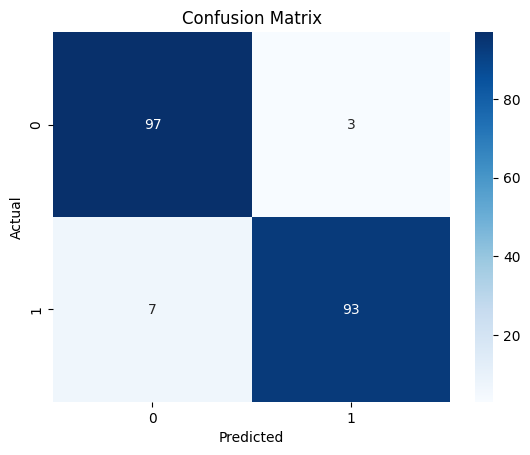

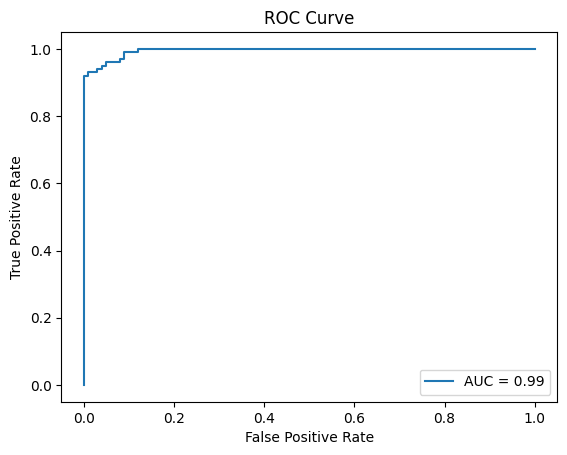

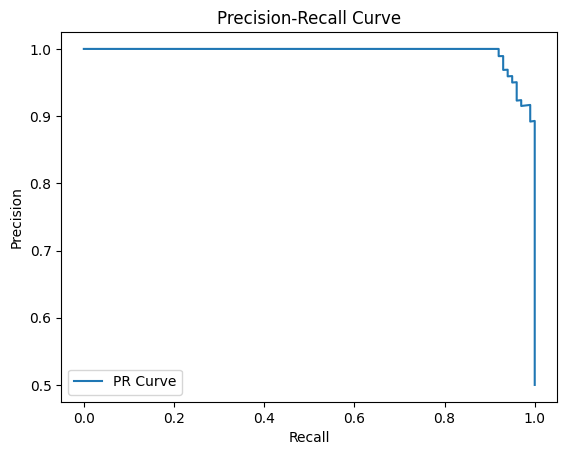

In [ ]:
# Import Necessary Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split
from PIL import Image

# Parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)  # Ensure float32
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image.float(), label  # Convert image to float32

# Data Preprocessing Function
def preprocess_data(cancer_dir, no_cancer_dir, img_size=(224, 224)):
    def load_images_from_folder(folder, label):
        images, labels = [], []
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            with Image.open(filepath) as img:
                img = img.resize(img_size)
                img_array = np.array(img)
                if img_array.ndim == 2:  # Convert grayscale to RGB
                    img_array = np.stack([img_array] * 3, axis=-1)
                images.append(img_array)
                labels.append(label)
        return np.array(images), np.array(labels)

    cancer_images, cancer_labels = load_images_from_folder(cancer_dir, 1)
    no_cancer_images, no_cancer_labels = load_images_from_folder(no_cancer_dir, 0)

    X = np.concatenate((cancer_images, no_cancer_images), axis=0)
    y = np.concatenate((cancer_labels, no_cancer_labels), axis=0)

    return X / 255.0, y  # Normalize to [0, 1]

# Hybrid Transfer Learning Feature Extractor using ResNet50
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Remove final FC layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        return self.fc(x)

# Gradient Reversal Layer for DANN
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd):
    return GradReverse.apply(x, lambd)

# Domain Discriminator
class DomainDiscriminator(nn.Module):
    def __init__(self):
        super(DomainDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lambd):
        x = grad_reverse(x, lambd)
        return self.fc(x)

# DANN + IRM + Transfer Learning Model
class DANN_IRM_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(DANN_IRM_Model, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(512, num_classes)
        self.domain_discriminator = DomainDiscriminator()

    def forward(self, x, lambd):
        features = self.feature_extractor(x)
        class_preds = self.classifier(features)
        domain_preds = self.domain_discriminator(features, lambd)
        return class_preds, domain_preds

# Training Function
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        lambd = 2 / (1 + np.exp(-10 * epoch / EPOCHS)) - 1  # Lambda schedule

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            class_preds, domain_preds = model(images, lambd)
            loss_class = criterion_class(class_preds, labels.long())

            domain_labels = torch.cat(
                [torch.ones(class_preds.size(0) // 2), torch.zeros(class_preds.size(0) // 2)]
            ).to(DEVICE).unsqueeze(1).float()  # Ensure correct shape and type

            loss_domain = criterion_domain(domain_preds, domain_labels)
            loss = loss_class + 0.1 * loss_domain  # Weighted sum
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f}")

# Evaluation Function
def evaluate_model():
    model.eval()
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            class_preds, _ = model(images, lambd=0)
            _, preds = torch.max(class_preds, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(class_preds.softmax(dim=1)[:, 1].cpu().numpy())

    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    return all_labels, all_preds, all_scores

# Plotting Functions
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

# Load Data
cancer_dir = "/content/drive/MyDrive/colab/1"
no_cancer_dir = "/content/drive/MyDrive/colab/0"
X, y = preprocess_data(cancer_dir, no_cancer_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_loader = DataLoader(CustomDataset(X_train, y_train, transform=transforms.ToTensor()), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(CustomDataset(X_test, y_test, transform=transforms.ToTensor()), batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
model = DANN_IRM_Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.BCELoss()

# Train & Evaluate
train_model()
y_true, y_pred, y_scores = evaluate_model()
plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_scores)
plot_precision_recall_curve(y_true, y_scores)


# New section

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 0.9350
Precision: 0.9579
Recall: 0.9100
F1 Score: 0.9333


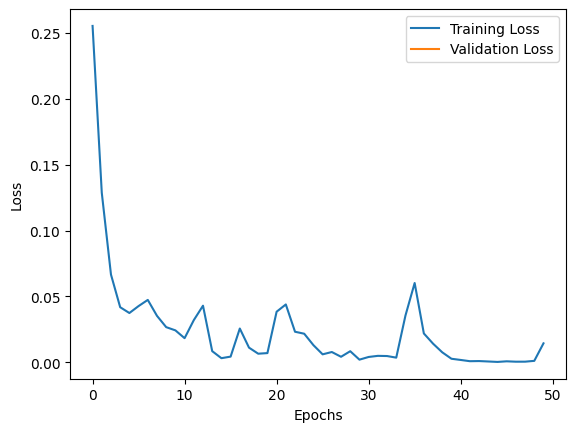

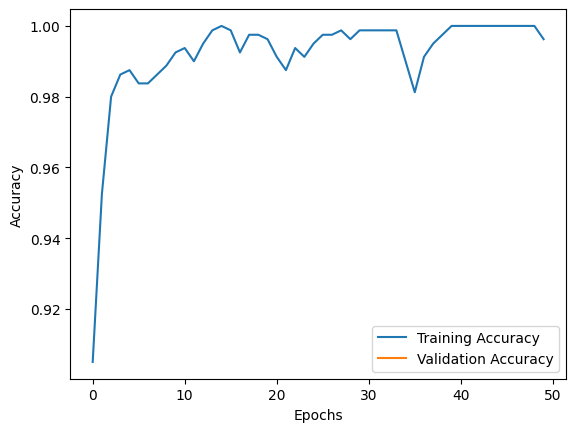

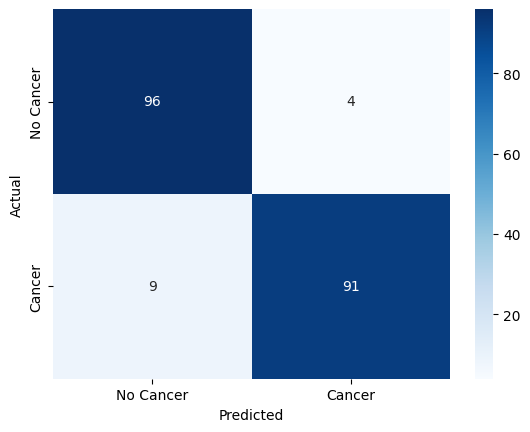

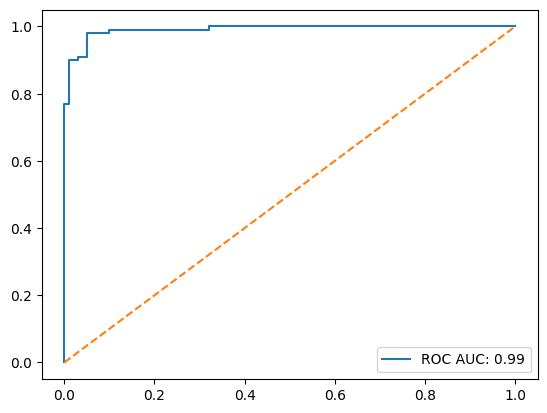

In [ ]:
# Import Necessary Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# Parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preprocessing
def preprocess_data(cancer_dir, no_cancer_dir, img_size=(224, 224)):
    from PIL import Image

    def load_images_from_folder(folder, label):
        images = []
        labels = []
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            with Image.open(filepath) as img:
                img = img.resize(img_size)
                img_array = np.array(img)
                if img_array.ndim == 2:  # Convert grayscale to RGB
                    img_array = np.stack([img_array] * 3, axis=-1)
                images.append(img_array)
                labels.append(label)
        return np.array(images), np.array(labels)

    cancer_images, cancer_labels = load_images_from_folder(cancer_dir, 1)
    no_cancer_images, no_cancer_labels = load_images_from_folder(no_cancer_dir, 0)

    X = np.concatenate((cancer_images, no_cancer_images), axis=0)
    y = np.concatenate((cancer_labels, no_cancer_labels), axis=0)

    return X / 255.0, y  # Normalize to [0, 1]

# Feature Extractor (ResNet50)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

# DANN + IRM Model
class DANN_IRM_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(DANN_IRM_Model, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        class_preds = self.classifier(features)
        return class_preds

# Load and Prepare Data
cancer_dir = r"/content/drive/MyDrive/colab/1"
no_cancer_dir = r"/content/drive/MyDrive/colab/0"
X, y = preprocess_data(cancer_dir, no_cancer_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
model = DANN_IRM_Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training Loop
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        class_preds = model(images)
        loss = criterion(class_preds, labels.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_acc.append(correct / total)

# Plotting Functions
def plot_training_loss():
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_training_accuracy():
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"ROC AUC: {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.legend()
    plt.show()

# Evaluate Model
model.eval()
all_preds, all_labels, all_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        class_preds = model(images)
        _, preds = torch.max(class_preds, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(class_preds.softmax(dim=1)[:, 1].cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Execute Plots
plot_training_loss()
plot_training_accuracy()
plot_confusion_matrix(all_labels, all_preds)
plot_roc_curve(all_labels, all_scores)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.9MB/s]


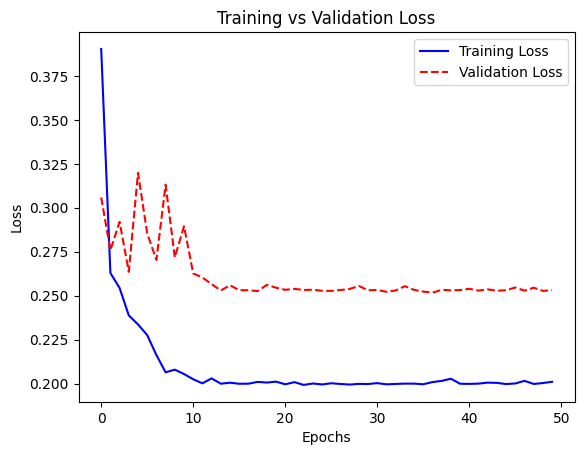

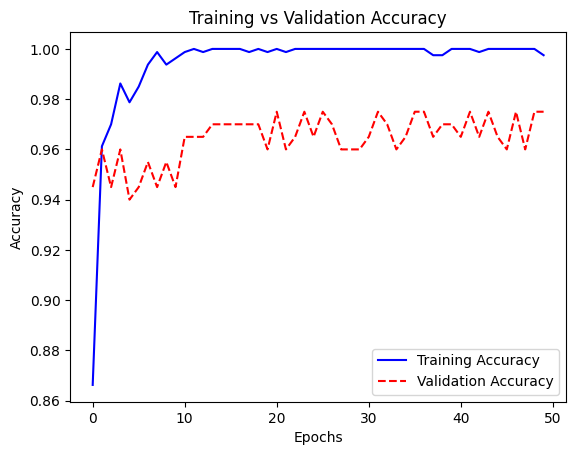

In [ ]:
# Import Necessary Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# Parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-4  # L2 Regularization
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preprocessing
def preprocess_data(cancer_dir, no_cancer_dir, img_size=(224, 224)):
    from PIL import Image

    def load_images_from_folder(folder, label):
        images = []
        labels = []
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            with Image.open(filepath) as img:
                img = img.resize(img_size)
                img_array = np.array(img)
                if img_array.ndim == 2:
                    img_array = np.stack([img_array] * 3, axis=-1)
                images.append(img_array)
                labels.append(label)
        return np.array(images), np.array(labels)

    cancer_images, cancer_labels = load_images_from_folder(cancer_dir, 1)
    no_cancer_images, no_cancer_labels = load_images_from_folder(no_cancer_dir, 0)

    X = np.concatenate((cancer_images, no_cancer_images), axis=0)
    y = np.concatenate((cancer_labels, no_cancer_labels), axis=0)

    return X / 255.0, y

# Model Components
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(2048, 512), nn.ReLU())

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd):
    return GradReverse.apply(x, lambd)

class DomainDiscriminator(nn.Module):
    def __init__(self):
        super(DomainDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lambd):
        x = grad_reverse(x, lambd)
        return self.fc(x)

class DANN_IRM_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(DANN_IRM_Model, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(512, num_classes)
        self.domain_discriminator = DomainDiscriminator()

    def forward(self, x, lambd):
        features = self.feature_extractor(x)
        class_preds = self.classifier(features)
        domain_preds = self.domain_discriminator(features, lambd)
        return class_preds, domain_preds

# Load Data
cancer_dir = r"/content/drive/MyDrive/colab/1"
no_cancer_dir = r"/content/drive/MyDrive/colab/0"
X, y = preprocess_data(cancer_dir, no_cancer_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(), transforms.RandomHorizontalFlip(), transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
model = DANN_IRM_Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion_class = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_domain = nn.BCELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Loop
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        class_preds, _ = model(images, lambd=0)
        loss = criterion_class(class_preds, labels.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_acc.append(correct / total)

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            class_preds, _ = model(images, lambd=0)
            loss = criterion_class(class_preds, labels.long())

            val_loss += loss.item()
            val_correct += (class_preds.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_acc.append(val_correct / val_total)

    scheduler.step()

# Plotting Functions
def plot_training_loss():
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="red", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()

def plot_training_accuracy():
    plt.plot(train_acc, label="Training Accuracy", color="blue")
    plt.plot(val_acc, label="Validation Accuracy", color="red", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy")
    plt.show()

# Execute Plots
plot_training_loss()
plot_training_accuracy()
